In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

# animations, etc. requires below magic command
# %matplotlib notebook


"""
Load relevant packages
"""

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation, cm

from scipy import stats
from scipy import optimize
from scipy.optimize import minimize
from functools import reduce


import autograd
from statsmodels.tools.numdiff import approx_fprime, approx_hess

from typing import Union, List

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data
from codelib.fixed_income.curves.nelson_siegel_curve import NelsonSiegelCurve
from codelib.fixed_income.curves.constant_curve import ConstantCurve
from codelib.fixed_income.cash_flows import CashFlow

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# Implementing curve and cash flow classes

In this lecture note, we will define a discount curve class and cash flow class that enables us to utilize the power of object oriented programming. 

Please take the DataCamp course [Object Oriented Programming in Python](https://app.datacamp.com/learn/courses/object-oriented-programming-in-python) before starting reading this notebook. 


## Implementing a discount curve

In the lecture note `extracting_yield_curves.ipynb`, we implement different yield curves. One example was the often used parameterization of the term structure of interest by [Nelson and Siegel (1987)](https://www.jstor.org/stable/2352957). They specified the following parameterization of the instantaneous forward rate

$$
f(\tau) = \beta_0 + \beta_1 e^{-\tau / \theta} + \beta_2 \frac{\tau}{\theta} e^{-\tau / \theta} 
$$

From newly gained knowledge, we know that the continuous zero coupon yield can be written as

$$
y(\tau) = \frac{1}{\tau} \intop_{0}^\tau f(u)  du = \beta_0 + \beta_1 \frac{1 - e^{-\tau / \theta}}{\tau / \theta} + \beta_2 \left(\frac{1 - e^{-\tau / \theta}}{\tau / \theta} - e^{-\tau / \theta} \right)
$$

One possibility would be to follow the same steps as in the previous lecture note, i.e. defining different functions responsible for each step in the calibration / estimation of the term structure model. Another possibility would be to define a class that represents a yield curve and  contains the methods necessary for calibrating the model.

When defining different curves, we will create a "generic" curve (abstract class) which contains the methods that we will require all different yield curves to implement. See `codelib.fixed_income.curves.curve_interface`  in the course repository.

Next, we will define a particular implementation of a yield curve namely the Nelson-Siegel curve. See `codelib.fixed_income.curves.nelson_siegel_curve`  in the course repository.

__Example: Nelson-Siegel__


In [2]:
"""
Get Nelson-Siegel parameters
"""

all_ns_parameters = get_nominal_yield_data(output_type='parameters')
ns_parameters = all_ns_parameters.loc['1979-12-31']
ns_parameters

BETA0     10.422117
BETA1      2.257780
BETA2     -4.595086
BETA3      0.000000
TAU1       2.197646
TAU2    -999.990000
Name: 1979-12-31 00:00:00, dtype: float64

In [3]:
"""
Get Nelson-Siegel yields
"""

all_ns_yields = get_nominal_yield_data(output_type='zero_yields')
ns_yields = all_ns_yields.loc['1979-12-31'].values
ns_tenors = np.arange(1.0, 31.0, 1.0)

In [4]:
all_ns_yields.loc['1979-12-31']

SVENY01    11.4596
SVENY02    10.7371
SVENY03    10.3205
SVENY04    10.0904
SVENY05     9.9727
SVENY06     9.9215
SVENY07     9.9088
SVENY08     9.9175
SVENY09     9.9374
SVENY10     9.9624
SVENY11     9.9891
SVENY12    10.0154
SVENY13    10.0405
SVENY14    10.0637
SVENY15    10.0850
SVENY16        NaN
SVENY17        NaN
SVENY18        NaN
SVENY19        NaN
SVENY20        NaN
SVENY21        NaN
SVENY22        NaN
SVENY23        NaN
SVENY24        NaN
SVENY25        NaN
SVENY26        NaN
SVENY27        NaN
SVENY28        NaN
SVENY29        NaN
SVENY30        NaN
Name: 1979-12-31 00:00:00, dtype: float64

In [5]:
"""
Create Nelson-Siegel curve
"""

ns_curve = NelsonSiegelCurve(theta=ns_parameters['TAU1'],
                             beta0=ns_parameters['BETA0'],
                             beta1=ns_parameters['BETA1'],
                             beta2=ns_parameters['BETA2'])

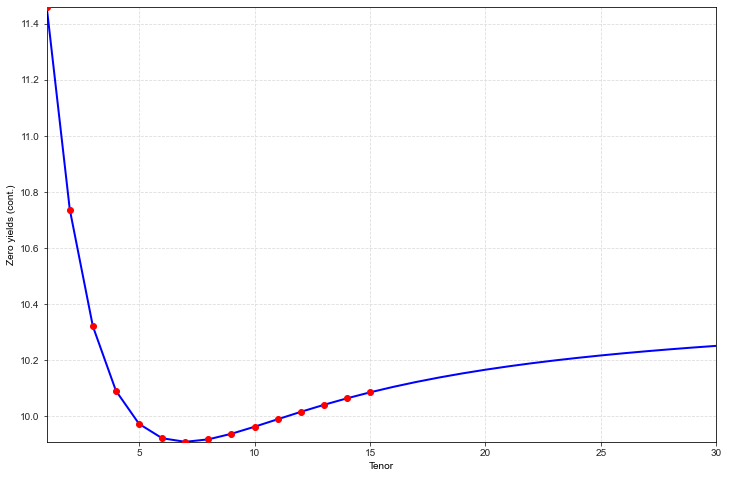

In [6]:
"""
Plot 
"""

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(ns_tenors, ns_curve.zero_rate_vector(ns_tenors), color="blue")
plt.scatter(ns_tenors, ns_yields, color="red", zorder=10)
ax.set_xlabel('Tenor');
ax.set_ylabel('Zero yields (cont.)');

In [7]:
"""
Can we back out the correct parameters?
"""

input_zero_rates = all_ns_yields.loc['1979-12-31'].dropna().values / 100.0
input_tenors = np.arange(1.0, 15.01, 1.0)
market_prices = np.exp(-input_tenors * input_zero_rates)
cash_flow_matrix = np.eye(15)


ns_curve_est = NelsonSiegelCurve.create_from_cash_flow_matrix(payments_dates=input_tenors, 
                                                              cash_flow_matrix=cash_flow_matrix,
                                                              market_prices=market_prices,
                                                              grid=slice(0.01, 25.0))

# Note: Betas scaled with 100
ns_curve_est.get_coefficients()

{'theta': 2.1974560546875006,
 'beta0': 0.1042201244547117,
 'beta1': 0.0225800341280068,
 'beta2': -0.04594900065161337}

## Implementing a cash flow class

Working with cash flows is at the heart of fixed income modelling! To find the price of a bond we need to discount its cash flows with appropriate discount rate. See `codelib.fixed_income.cash_flows` for an implementation of a cash flow object (it is assumed that we are working purely with continuous discounting). 

__Example: Working with cash flow__

In [8]:
"""
Create a constant zero yield curve
"""

constant_curve = ConstantCurve(rate = 0.02)
constant_curve.zero_rate_vector(np.arange(1.0, 11.0, 1.0))

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

In [9]:
"""
Create a cash flow and calculate present value using CashFlow class
"""

time_points = np.arange(1.0, 10.0 + 1.0, 1.0)
flows = np.ones_like(time_points) * 5 
flows[-1] += 100

cash_flow = CashFlow(time_points=time_points, flows=flows)
pv = cash_flow.present_value(curve=constant_curve)
pv

126.73872448798494

In [10]:
"""
Duration
"""

duration = cash_flow.fisher_weil_duration(curve=constant_curve)
duration

8.348624112792544

In [11]:
"""
We can approximate price change from a 1 bps rate change as 
"""

duration * pv * 0.0001

0.1058093971284962

In [12]:
"""
The exact price change
"""

constant_curve_new = ConstantCurve(rate = 0.0201)
pv_new = cash_flow.present_value(curve=constant_curve_new)
pv_new

126.63296424374133

In [13]:
pv - pv_new

0.10576024424361208

In [14]:
"""
Convexity
"""

convexity = cash_flow.fisher_weil_convexity(curve=constant_curve)
convexity

77.59058655943717

# References

## Articles

[McCulloch (1975)](https://www.jstor.org/stable/2326860)

[Svensson (1994)](https://www.nber.org/papers/w4871)

[Nelson and Siegel (1987)](https://www.jstor.org/stable/2352957)

## Books

[Claus Munk (2013), "Fixed income modelling"](https://www.amazon.co.uk/Fixed-Income-Modelling-Claus-Munk/dp/0198716443)
